In [3]:
# Analysis of the data. 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm, trange
from pandas.plotting import register_matplotlib_converters

import pandas as pd
import os
import glob
import shutil
from pathlib import Path
from os import listdir
from os.path import isfile, join
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import Dataset
import cv2

import torch_model #helper functions
import helper

import albumentations as A
from albumentations.pytorch import ToTensor

import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

import importlib


In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
print (train_on_gpu)
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [2]:
# Import dataset summary and metadata.

dir_summary = Path("data")
fileName = 'Chest_xray_Corona_dataset_Summary.csv'
%time data_summary = pd.read_csv(dir_summary / fileName)
data_summary = data_summary.iloc[:,1:] # delete first column
print(fileName, ' imported')

fileName = 'Chest_xray_Corona_Metadata.csv'
%time metadata = pd.read_csv(dir_summary / fileName)
metadata = metadata.iloc[:,1:] # delete first column
metadata = metadata.fillna("")
print(fileName, ' imported')
metadata['folder'] = ""

# indicate a folder to each image
for i in range(0,len(metadata)) :
    if metadata.iloc[i,3] != "":
        metadata.iloc[i,5] =  metadata.iloc[i,1] + "-" +  metadata.iloc[i,4] + "-" +  metadata.iloc[i,3]
    elif metadata.iloc[i,4] != "":
        metadata.iloc[i,5] =  metadata.iloc[i,1] + "-" +  metadata.iloc[i,4]
    else:
        metadata.iloc[i,5] =  metadata.iloc[i,1]

Wall time: 461 ms
Chest_xray_Corona_dataset_Summary.csv  imported
Wall time: 30.8 ms
Chest_xray_Corona_Metadata.csv  imported


In [ ]:
metadata.loc[metadata['Dataset_type'] == 'TEST'].groupby(['folder']).count()

In [ ]:
data_summary

In [ ]:
os.makedirs("data/train/Normal", exist_ok=True)
os.makedirs("data/train/Pnemonia-bacteria", exist_ok=True)
os.makedirs("data/train/Pnemonia-bacteria-Streptococcus", exist_ok=True)
os.makedirs("data/train/Pnemonia-Stress-Smoking-ARDS", exist_ok=True)
os.makedirs("data/train/Pnemonia-Virus", exist_ok=True)
os.makedirs("data/train/Pnemonia-Virus-COVID-19", exist_ok=True)
os.makedirs("data/train/Pnemonia-Virus-SARS", exist_ok=True)


In [ ]:
## Move images to train folder ##

# Get images names
src_folder = "data/Coronahack-Chest-XRay-Dataset/train"
dest_folder = "data/train" 
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))]
# Save each image in its corresponding class directory
counter = 0
for f in tqdm(images):
    if metadata.loc[metadata['X_ray_image_name'] == f].shape[0] > 0:
#         if 'Pnemonia-Virus-COVID-19' == metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]:
        class_folder = metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]
        shutil.copy(os.path.join(src_folder, f), os.path.join(dest_folder, class_folder))
        counter += 1

print("archives: ", counter)

In [ ]:
## Move images to test folder ##

# Get images names
src_folder = "data/Coronahack-Chest-XRay-Dataset/test"
dest_folder = "data/test" 
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))]
# Save each image in its corresponding class directory
counter = 0
for f in tqdm(images):
    if metadata.loc[metadata['X_ray_image_name'] == f].shape[0] > 0:
#         if 'Pnemonia-Virus-COVID-19' == metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]:
        class_folder = metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]
        shutil.copy(os.path.join(src_folder, f), os.path.join(dest_folder, class_folder))
        counter += 1

print("archives: ", counter)

In [10]:
# Compose transforms
editions = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(256),
#                                transforms.ColorJitter(),
#                                transforms.RandomGrayscale(),
                               transforms.RandomRotation(4),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   # new thing                            
                              ])

# editions = A.Compose([
#                     A.HorizontalFlip(p=0.5),
#                     A.RandomGamma(gamma_limit=(20, 300), p=0.5),
#                     A.Blur(always_apply=False, p=1.0, blur_limit=(3, 7)),
#                     A.RandomBrightnessContrast(p=0.85),
#                     A.Rotate(limit=4, p=0.9),
#                     A.GaussNoise(p=0.25),
#                     A.HueSaturationValue(p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
# #                     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# #                     ToTensor()
#                     ])

train_data =  datasets.ImageFolder('data/train', transform=editions) # create the ImageFolder
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True) # use the ImageFolder dataset to create the DataLoader
test_data =  datasets.ImageFolder('data/test', transform=editions) # create the ImageFolder
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True) 

In [ ]:

helper.imshow(train_data[3][0], normalize=False)

In [ ]:
# test data loader
images, labels = next(iter(train_loader))
helper.imshow(images[0], normalize=False)

In [ ]:
# change this to the trainloader or testloader 
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax)

In [ ]:
# Create the network, define the criterion and optimizer
model = torch_model.Network(196608, 7, [512, 256, 128, 64], drop_p=0.1)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
print(model)

In [ ]:
importlib.reload(torch_model)
import train

In [12]:
importlib.reload(prova)

modulo importado como name


<module 'prova' from 'C:\\Users\\rodri\\OneDrive\\Documentos\\GitHub\\Xrays_covid_model\\prova.py'>

In [29]:
!python feed_forward_net/train.py

Get data loader.


100%|##########| 5/5 [40:53<00:00, 490.62s/it]
Traceback (most recent call last):
  File "feed_forward_net/train.py", line 234, in <module>
    train(model, train_loader, test_loader, args.epochs, optimizer, criterion, device)
  File "feed_forward_net/train.py", line 122, in train
    save_model(model, args.model_dir)
  File "feed_forward_net/train.py", line 136, in save_model
    torch.save(checkpoint, path)
NameError: name 'path' is not defined



Num of batches in train data:  204
Get data loader.
Num of batches in test data:  20
Starting training with 5 epochs
Epoch: 1/5..  Training Loss: 3.626..  Test Loss: 1.640..  Test Accuracy: 0.516 Test Accuracy2: 0.739
Epoch: 2/5..  Training Loss: 1.331..  Test Loss: 1.259..  Test Accuracy: 0.489 Test Accuracy2: 0.718
Epoch: 3/5..  Training Loss: 1.334..  Test Loss: 1.376..  Test Accuracy: 0.386 Test Accuracy2: 0.631
Epoch: 4/5..  Training Loss: 1.369..  Test Loss: 1.355..  Test Accuracy: 0.382 Test Accuracy2: 0.631
Epoch: 5/5..  Training Loss: 1.357..  Test Loss: 1.340..  Test Accuracy: 0.384 Test Accuracy2: 0.630
Saving the model.


In [ ]:
import feed_forward_net.train

In [ ]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
#     model.cuda()
    model.to("cuda")

In [ ]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path = output_path
                    hyperparameters={
                        'input_dim': 2,
                        'hidden_dim': 20,
                        'ouput_dim': 1,
                        'epochs': 80
                    })

In [ ]:
%%time
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
torch_model.train(model, train_loader, test_loader, criterion, optimizer, "cpu", epochs=1)

In [ ]:
def view_classify_covid_19(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 256, 256).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(1,8), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(1,8))
    ax2.set_yticklabels(np.arange(1,8))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
# Test network
model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[1]
img_squezeed = img.view(1, 196608)
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img_squezeed)
ps = torch.exp(output)

print(labels[1])

In [ ]:
%%time
# model.cpu()
torch_model.validation(model,test_loader)
# preciso medir os falsos positivos. 

In [ ]:
metadata.loc[metadata["Dataset_type"] == "TEST"].groupby(["folder"]).count()

In [ ]:
# save model

checkpoint = {'input_size': 196608,
              'output_size': 7,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

nome = 'normalizado'
torch.save(checkpoint, nome + '.pth')

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = torch_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model
nome = 'normalizado'
model = load_checkpoint(nome + '.pth')
print(model)

# Data augmentation

In [ ]:
# From https://www.curiousily.com/posts/image-data-augmentation-for-tensorflow-2-keras-and-pytorch-with-albumentations-in-python/
def show_image(image):
    f = plt.figure(figsize=(18, 12))
    plt.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()

def show_augmented(augmentation, image):
    augmented = augmentation(image=image)
    show_image(augmented['image'])

In [ ]:
doc_aug = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
                    A.Blur(always_apply=False, p=1.0, blur_limit=(3, 7)),
                    A.RandomBrightnessContrast(p=0.85),
                    A.Rotate(limit=4, p=0.9),
                    A.GaussNoise(p=0.25),
                    A.HueSaturationValue(p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20))
                    ])

In [ ]:
# First test augmentation of 1 image
# Second, test augmentation of n different images for each 


src_folder = "data/train/Pnemonia-Virus-COVID-19"
DATASET_PATH = 'data/augmented'
IMAGES_PATH = f'{DATASET_PATH}/Pnemonia-Virus-COVID-19'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))] # get images names

for i in trange(50):
    xray = cv2.imread( os.path.join("data/train/Pnemonia-Virus-COVID-19", images[i]) )
    for k in range(25):
        augmented = doc_aug(image=xray)
        file_name = f'foto_aug_{i}_{k}.jpg'
        cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

# CNN with transfer learning

In [4]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\rodri/.cache\torch\checkpoints\vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [5]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [6]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [8]:
n_inputs = vgg16.classifier[6].in_features
classes= [1,2,3,4,5,6,7]
# add last linear layer (n_inputs -> 7 lung classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
# if train_on_gpu:
#     vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

7


In [9]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

Epoch: 1/2..  Training Loss: 0.666..  Test Loss: 0.861..  Test Accuracy: 0.723 Test Accuracy2: 0.797
Epoch: 2/2..  Training Loss: 0.489..  Test Loss: 0.731..  Test Accuracy: 0.763 Test Accuracy2: 0.835


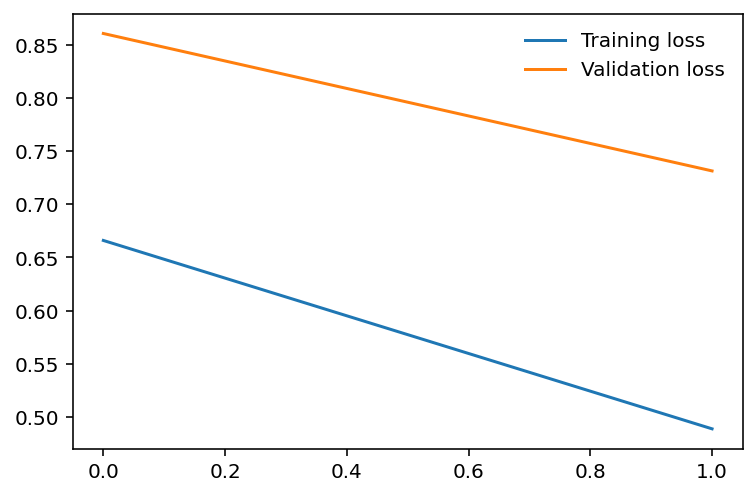

In [12]:
%%time
steps = 0
train_losses, test_losses = [], []
device="cpu"
epochs = 2
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        log_ps = vgg16(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0
        accuracy2 = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            vgg16.eval()
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = vgg16(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) # get highest probability. It returns a tuple with the probability and its index
                equals = top_class == labels.view(*top_class.shape) # transform labels to size (batch, 1) to compare with top class
                accuracy += torch.mean(equals.type(torch.FloatTensor))

                # calculate accuracy only between normal lung and sick (2 classes):
                originais = labels.view(*top_class.shape)
                mask = originais[:,0]>=1
                originais[mask,:] = 1
                new_pred = top_class
                mask = new_pred[:,0]>=1
                new_pred[mask,:] = 1
                equals2 = new_pred == originais
                accuracy2 += torch.mean(equals2.type(torch.FloatTensor))

        vgg16.train()

        # Save values to show on a graph later
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        # Print stats
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
              "Test Accuracy2: {:.3f}".format(accuracy2/len(test_loader))
             )

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)